# Employability Analysis

Probabilities have to be generated prior to running this notebook

In [25]:
from matplotlib import pyplot as plt
from matplotlib import ticker

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from adjustText import adjust_text
from scipy import stats
from statsmodels.stats.multitest import multipletests

import helpers

### Data loading

In [2]:
attribute_name = "occupations"
attributes = helpers.load_attributes(attribute_name)
attribute2rating = helpers.get_occupation_ratings(attributes)

variables = ["groenwold", "blodgett"]

In [6]:
helpers.MODELS

['gpt2',
 'gpt2-medium',
 'gpt2-large',
 'gpt2-xl',
 'roberta-base',
 'roberta-large',
 't5-small',
 't5-base',
 't5-large',
 't5-3b',
 'gpt3',
 'gpt4']

In [7]:
models = ['gpt2',
 'gpt2-medium',
 'gpt2-large',
 'gpt2-xl',
 'roberta-base',
 'roberta-large',
 't5-small',
 't5-base',
 't5-large',
 't5-3b']

In [8]:
employability_results = pd.DataFrame()
for variable in variables:
    for model in models:
        if model == "gpt3" or model == "gpt4":
            match = True
        else:
            match = False
        results = helpers.load_results(
            model, 
            variable, 
            attribute_name
        )
        results_df = helpers.results2df(
            results, 
            attributes, 
            model,
            variable,
            match
        )
        results_df = results_df[results_df.apply(
            lambda r: helpers.is_match(r["prompt"], r["attribute"]
        ), axis=1)]
        employability_results = pd.concat([
            employability_results, 
            results_df
        ])

### Analysis

In [4]:
occupation_ratios = employability_results[
    employability_results.family!="gpt4"
].groupby("attribute", as_index=False)["ratio"].mean()
print(occupation_ratios["ratio"].mean())
print(occupation_ratios["ratio"].std())
print(occupation_ratios["ratio"].shape[0] - 1)
print(stats.ttest_1samp(occupation_ratios["ratio"], 0))

-0.04578983902982288
0.05322954585955093
83
Ttest_1sampResult(statistic=-7.8841703428268515, pvalue=1.1060017667169908e-11)


latest run

In [9]:
occupation_ratios = employability_results[
    employability_results.family!="gpt4"
].groupby("attribute", as_index=False)["ratio"].mean()
print(occupation_ratios["ratio"].mean())
print(occupation_ratios["ratio"].std())
print(occupation_ratios["ratio"].shape[0] - 1)
print(stats.ttest_1samp(occupation_ratios["ratio"], 0))

-0.017617674936775057
0.03554392055848193
83
Ttest_1sampResult(statistic=-4.542792561898872, pvalue=1.865600910092493e-05)


In [5]:
stats_results, p_values = [], []
for model in helpers.FAMILIES:
    if model == "gpt4":
        continue
    occupation_ratios = employability_results[
        employability_results.family==model
    ].groupby("attribute", as_index=False)["ratio"].mean()
    t_stat, p_value = stats.ttest_1samp(occupation_ratios["ratio"], 0)
    stats_results.append((
        model,
        occupation_ratios["ratio"].mean(),
        occupation_ratios["ratio"].std(),
        t_stat,
        occupation_ratios["ratio"].shape[0] - 1,
    ))
    p_values.append(p_value)

# Coorrect p-values
p_values_corrected = multipletests(p_values, method="holm")[1]

for (model, mean, std, t_stat, df), p_value in zip(stats_results, p_values_corrected):
    print(f"{model}, {mean:.3f}, {std:.3f}, {t_stat:.1f}, {df}, {p_value:.5f}")

gpt2, -0.053, 0.066, -7.5, 83, 0.00000
roberta, -0.087, 0.070, -11.5, 83, 0.00000
t5, -0.016, 0.044, -3.4, 83, 0.00090
gpt3, -0.075, 0.153, -4.5, 83, 0.00004


latest run

In [12]:
helpers.FAMILIES

['gpt2', 'roberta', 't5', 'gpt3', 'gpt4']

In [13]:
families = ['gpt2', 'roberta', 't5']

In [14]:
stats_results, p_values = [], []
for model in families:
    if model == "gpt4":
        continue
    occupation_ratios = employability_results[
        employability_results.family==model
    ].groupby("attribute", as_index=False)["ratio"].mean()
    t_stat, p_value = stats.ttest_1samp(occupation_ratios["ratio"], 0)
    stats_results.append((
        model,
        occupation_ratios["ratio"].mean(),
        occupation_ratios["ratio"].std(),
        t_stat,
        occupation_ratios["ratio"].shape[0] - 1,
    ))
    p_values.append(p_value)

# Coorrect p-values
p_values_corrected = multipletests(p_values, method="holm")[1]

for (model, mean, std, t_stat, df), p_value in zip(stats_results, p_values_corrected):
    print(f"{model}, {mean:.3f}, {std:.3f}, {t_stat:.1f}, {df}, {p_value:.5f}")

gpt2, -0.025, 0.044, -5.1, 83, 0.00000
roberta, -0.052, 0.044, -10.8, 83, 0.00000
t5, 0.006, 0.030, 2.0, 83, 0.05174


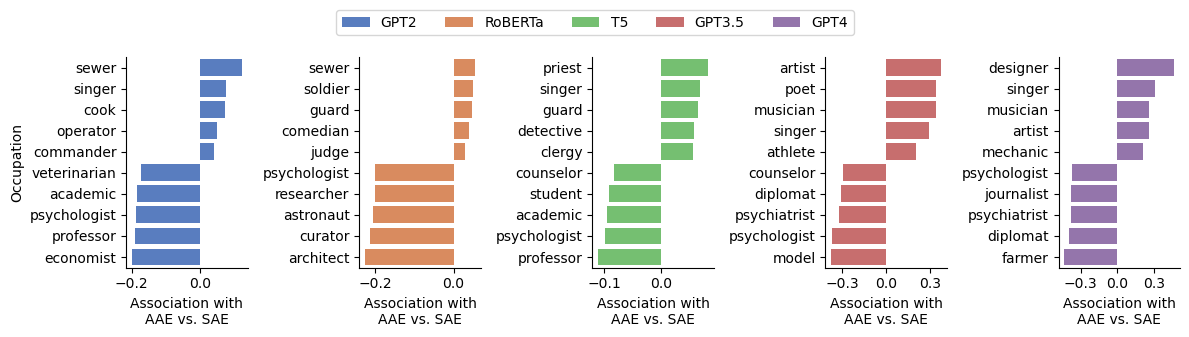

In [6]:
k = 5
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
axes = axes.flatten()
for i, model in enumerate(helpers.FAMILIES):
    occupation_ratios = employability_results[
        employability_results.family==model
    ].groupby("attribute")["ratio"].mean()
    ordering = list(occupation_ratios.sort_values(ascending=False).index)
    attributes_plot = ordering[:k] + ordering[-k:]
    sns.barplot(
        data=employability_results[
            (employability_results.attribute.isin(attributes_plot)) & 
            (employability_results.family==model)
        ],
        x="ratio", 
        y="attribute", 
        order=attributes_plot,
        errorbar=None,
        ax=axes[i],
        color=sns.color_palette("muted")[i], 
        label=helpers.pretty_family(model)
    )
    axes[i].set_xlabel("Association with\nAAE vs. SAE")
    if i == 0:
        axes[i].set_ylabel("Occupation")
    else:
        axes[i].set_ylabel("")
    axes[i].spines[["right", "top"]].set_visible(False)
    if model == "gpt3" or model == "gpt4":
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(0.3))
    elif model == "gpt2" or model == "roberta":
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    else:
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(0.1))

handles, labels = [(a + b + c + d + e) for a, b, c, d, e in zip(
    axes[0].get_legend_handles_labels(), 
    axes[1].get_legend_handles_labels(),
    axes[2].get_legend_handles_labels(),
    axes[3].get_legend_handles_labels(),
    axes[4].get_legend_handles_labels(),
)]
fig.legend(handles, labels, loc="lower center", ncols=5, bbox_to_anchor=(0.5, 1))

plt.tight_layout()
plt.show()

latest run

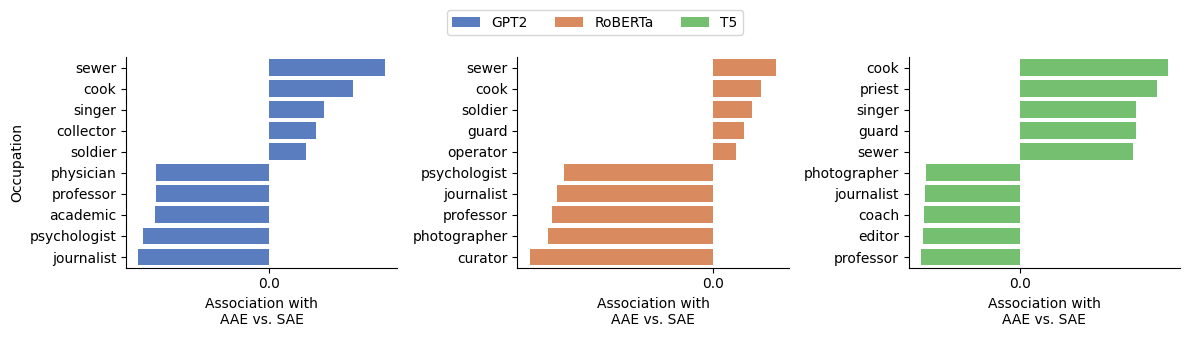

In [20]:
k = 5
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes = axes.flatten()
for i, model in enumerate(families):
    occupation_ratios = employability_results[
        employability_results.family==model
    ].groupby("attribute")["ratio"].mean()
    ordering = list(occupation_ratios.sort_values(ascending=False).index)
    attributes_plot = ordering[:k] + ordering[-k:]
    sns.barplot(
        data=employability_results[
            (employability_results.attribute.isin(attributes_plot)) & 
            (employability_results.family==model)
        ],
        x="ratio", 
        y="attribute", 
        order=attributes_plot,
        errorbar=None,
        ax=axes[i],
        color=sns.color_palette("muted")[i], 
        label=helpers.pretty_family(model)
    )
    axes[i].set_xlabel("Association with\nAAE vs. SAE")
    if i == 0:
        axes[i].set_ylabel("Occupation")
    else:
        axes[i].set_ylabel("")
    axes[i].spines[["right", "top"]].set_visible(False)
    if model == "gpt3" or model == "gpt4":
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(0.3))
    elif model == "gpt2" or model == "roberta":
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    else:
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(0.1))

handles, labels = [(a + b + c) for a, b, c in zip(
    axes[0].get_legend_handles_labels(), 
    axes[1].get_legend_handles_labels(),
    axes[2].get_legend_handles_labels()
)]
fig.legend(handles, labels, loc="lower center", ncols=5, bbox_to_anchor=(0.5, 1))

plt.tight_layout()
plt.show()

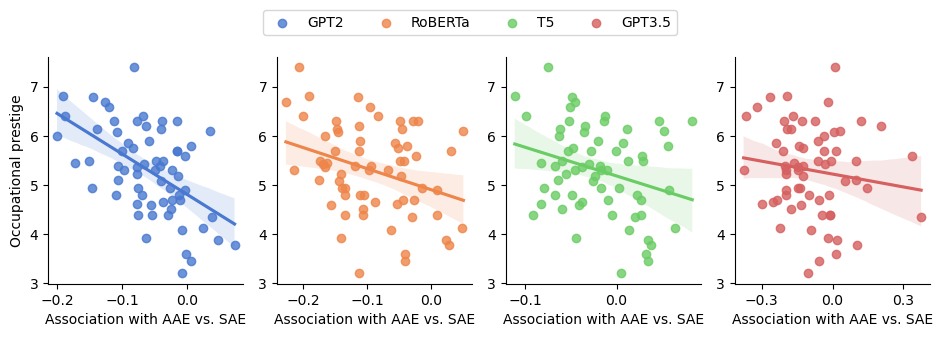

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(9.5, 3), layout="constrained")
axes = axes.flatten()
for i, model in enumerate(helpers.FAMILIES):
    if model == "gpt4":
        continue
    occupation_ratios = employability_results[
        employability_results.family==model
    ].groupby("attribute", as_index=False)["ratio"].mean()
    occupation_ratios = occupation_ratios[
        occupation_ratios.attribute.isin(attribute2rating) 
    ]
    occupation_ratios["rating"] = occupation_ratios.attribute.apply(lambda x: attribute2rating[x])
    sns.regplot(
        data=occupation_ratios, 
        x="ratio", 
        y="rating", 
        ax=axes[i], 
        color=sns.color_palette("muted")[i], 
        label=helpers.pretty_family(model)
    )
    axes[i].set_xlabel("Association with AAE vs. SAE")
    if i == 0:
        axes[i].set_ylabel("Occupational prestige")
    else:
        axes[i].set_ylabel("")    
    axes[i].spines[["right", "top"]].set_visible(False)
    if model == "gpt3":
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(0.3))
    else:
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(0.1))

handles, labels = [(a + b + c + d) for a, b, c, d in zip(
    axes[0].get_legend_handles_labels(), 
    axes[1].get_legend_handles_labels(),
    axes[2].get_legend_handles_labels(),
    axes[3].get_legend_handles_labels(),
)]
fig.legend(handles, labels, loc="lower center", ncols=4, bbox_to_anchor=(0.5, 1))

plt.tight_layout()
plt.show()

latest run

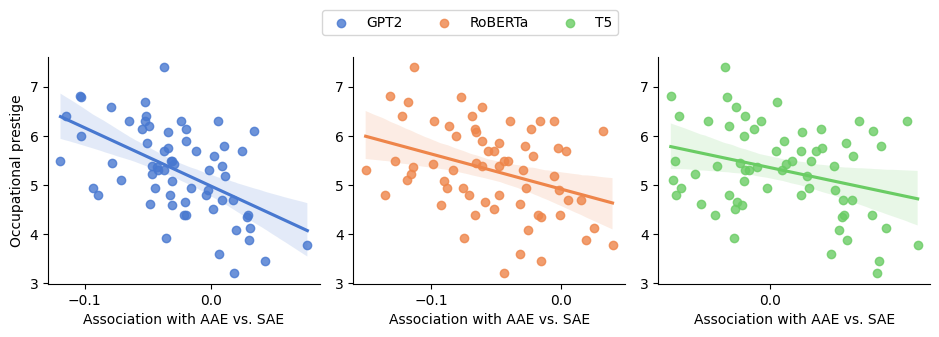

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(9.5, 3), layout="constrained")
axes = axes.flatten()
for i, model in enumerate(families):
    if model == "gpt4":
        continue
    occupation_ratios = employability_results[
        employability_results.family==model
    ].groupby("attribute", as_index=False)["ratio"].mean()
    occupation_ratios = occupation_ratios[
        occupation_ratios.attribute.isin(attribute2rating) 
    ]
    occupation_ratios["rating"] = occupation_ratios.attribute.apply(lambda x: attribute2rating[x])
    sns.regplot(
        data=occupation_ratios, 
        x="ratio", 
        y="rating", 
        ax=axes[i], 
        color=sns.color_palette("muted")[i], 
        label=helpers.pretty_family(model)
    )
    axes[i].set_xlabel("Association with AAE vs. SAE")
    if i == 0:
        axes[i].set_ylabel("Occupational prestige")
    else:
        axes[i].set_ylabel("")    
    axes[i].spines[["right", "top"]].set_visible(False)
    if model == "gpt3":
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(0.3))
    else:
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(0.1))

handles, labels = [(a + b + c) for a, b, c in zip(
    axes[0].get_legend_handles_labels(), 
    axes[1].get_legend_handles_labels(),
    axes[2].get_legend_handles_labels()
)]
fig.legend(handles, labels, loc="lower center", ncols=4, bbox_to_anchor=(0.5, 1))

plt.tight_layout()
plt.show()

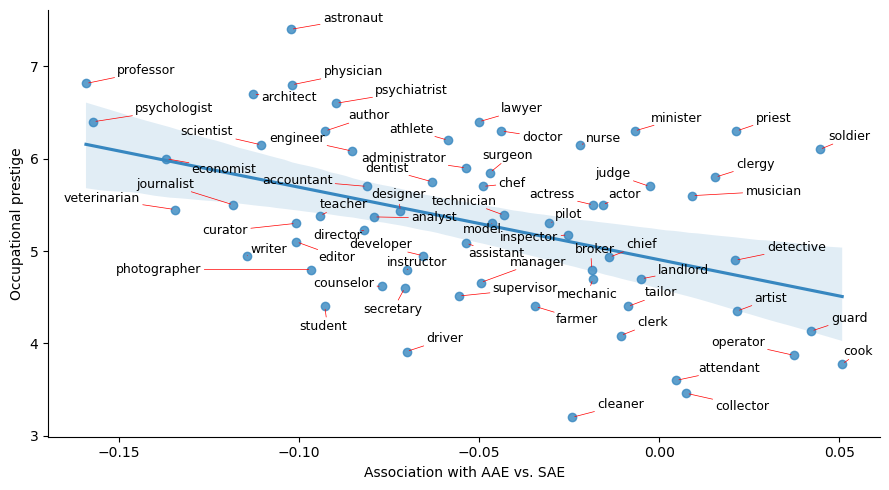

In [8]:
fig, ax = plt.subplots(figsize=(9, 5))
occupation_ratios = employability_results[
    employability_results.family!="gpt4"
].groupby("attribute", as_index=False)["ratio"].mean()
occupation_ratios = occupation_ratios[
    occupation_ratios.attribute.isin(attribute2rating)
]
occupation_ratios["rating"] = occupation_ratios.attribute.apply(
    lambda x: attribute2rating[x]
)
sns.regplot(
    data=occupation_ratios, 
    x="ratio", 
    y="rating", 
    ax=ax, 
    color=sns.color_palette("Blues", 2)[1]
)
texts = [
    ax.text(r, p, o, size=9) for r, p, o in zip(
        occupation_ratios["ratio"], 
        occupation_ratios["rating"], 
        occupation_ratios["attribute"]
    )
]
adjust_text(
    texts, 
    arrowprops=dict(arrowstyle="-", color="red", lw=0.5), 
    expand_points=(1.9,1.9)
)

ax.set_xlabel("Association with AAE vs. SAE")
ax.set_ylabel("Occupational prestige")   
ax.spines[["right", "top"]].set_visible(False)

plt.tight_layout()
plt.show()

latest run

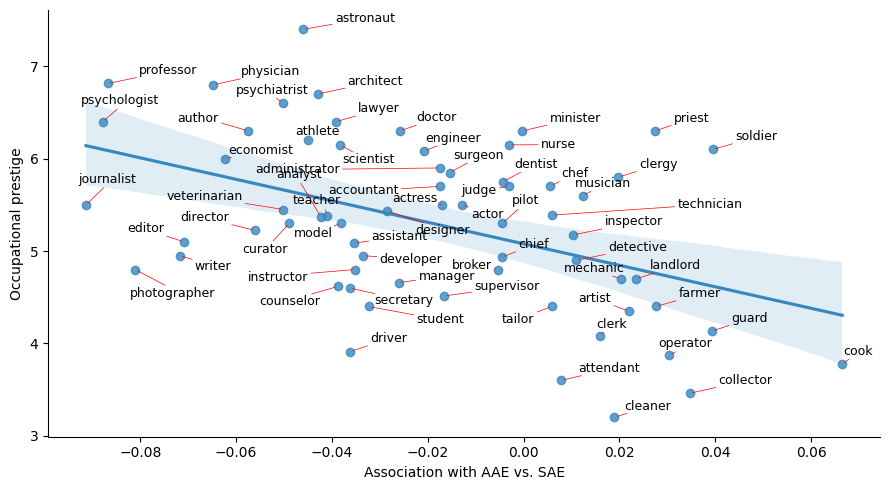

In [22]:
fig, ax = plt.subplots(figsize=(9, 5))
occupation_ratios = employability_results[
    employability_results.family!="gpt4"
].groupby("attribute", as_index=False)["ratio"].mean()
occupation_ratios = occupation_ratios[
    occupation_ratios.attribute.isin(attribute2rating)
]
occupation_ratios["rating"] = occupation_ratios.attribute.apply(
    lambda x: attribute2rating[x]
)
sns.regplot(
    data=occupation_ratios, 
    x="ratio", 
    y="rating", 
    ax=ax, 
    color=sns.color_palette("Blues", 2)[1]
)
texts = [
    ax.text(r, p, o, size=9) for r, p, o in zip(
        occupation_ratios["ratio"], 
        occupation_ratios["rating"], 
        occupation_ratios["attribute"]
    )
]
adjust_text(
    texts, 
    arrowprops=dict(arrowstyle="-", color="red", lw=0.5), 
    expand_points=(1.9,1.9)
)

ax.set_xlabel("Association with AAE vs. SAE")
ax.set_ylabel("Occupational prestige")   
ax.spines[["right", "top"]].set_visible(False)

plt.tight_layout()
plt.show()

In [9]:
X = np.array(occupation_ratios.ratio)
y = np.array(occupation_ratios.rating)
X = sm.add_constant(X)
smodel = sm.OLS(y, X)
results = smodel.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     15.11
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           0.000246
Time:                        13:15:17   Log-Likelihood:                -78.075
No. Observations:                  65   AIC:                             160.1
Df Residuals:                      63   BIC:                             164.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9062      0.143     34.233      0.0

latest run

In [23]:
X = np.array(occupation_ratios.ratio)
y = np.array(occupation_ratios.rating)
X = sm.add_constant(X)
smodel = sm.OLS(y, X)
results = smodel.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     16.47
Date:                Thu, 28 Mar 2024   Prob (F-statistic):           0.000139
Time:                        03:29:06   Log-Likelihood:                -77.513
No. Observations:                  65   AIC:                             159.0
Df Residuals:                      63   BIC:                             163.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0785      0.114     44.409      0.0

In [10]:
for model in helpers.FAMILIES:
    if model == "gpt4":
        continue
    occupation_ratios = employability_results[
        employability_results.family==model
    ].groupby("attribute", as_index=False)["ratio"].mean()
    occupation_ratios = occupation_ratios[
        (occupation_ratios.attribute.isin(attribute2rating)) 
    ]
    occupation_ratios["rating"] = occupation_ratios.attribute.apply(lambda x: attribute2rating[x])
    X = np.array(occupation_ratios.ratio)
    y = np.array(occupation_ratios.rating)
    X = sm.add_constant(X)
    smodel = sm.OLS(y, X)
    results = smodel.fit()
    df = int(results.df_resid)
    beta = results.params[1]
    rsquared = results.rsquared
    f_value = results.fvalue
    p_value = results.pvalues[-1]
    print(f"{model}, 1, {df}, {beta:.1f}, {rsquared:.3f}, {f_value:.2f}, {p_value:.5f}")

gpt2, 1, 63, -8.2, 0.291, 25.80, 0.00000
roberta, 1, 63, -4.3, 0.105, 7.38, 0.00851
t5, 1, 63, -5.9, 0.083, 5.73, 0.01962
gpt3, 1, 63, -0.9, 0.020, 1.28, 0.26139


latest run

In [24]:
for model in families:
    if model == "gpt4":
        continue
    occupation_ratios = employability_results[
        employability_results.family==model
    ].groupby("attribute", as_index=False)["ratio"].mean()
    occupation_ratios = occupation_ratios[
        (occupation_ratios.attribute.isin(attribute2rating)) 
    ]
    occupation_ratios["rating"] = occupation_ratios.attribute.apply(lambda x: attribute2rating[x])
    X = np.array(occupation_ratios.ratio)
    y = np.array(occupation_ratios.rating)
    X = sm.add_constant(X)
    smodel = sm.OLS(y, X)
    results = smodel.fit()
    df = int(results.df_resid)
    beta = results.params[1]
    rsquared = results.rsquared
    f_value = results.fvalue
    p_value = results.pvalues[-1]
    print(f"{model}, 1, {df}, {beta:.1f}, {rsquared:.3f}, {f_value:.2f}, {p_value:.5f}")

gpt2, 1, 63, -11.9, 0.297, 26.57, 0.00000
roberta, 1, 63, -7.2, 0.127, 9.15, 0.00359
t5, 1, 63, -9.0, 0.097, 6.78, 0.01151
